In [22]:
import pandas as pd
from cryptography.hazmat.backends.openssl import backend
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
import numpy as np
import shap
Xian_cohort = pd.read_csv('/Users/gengzhi/Desktop/Xian_cohort.csv')
nonXian_cohort = pd.read_csv('/Users/gengzhi/Desktop/nonXian_cohort.csv')
Xian_cohort = pd.concat([Xian_cohort, nonXian_cohort])
imputer = KNNImputer(n_neighbors=2)
# only 69th column have missing value
Xian_cohort['CRP'] = imputer.fit_transform(Xian_cohort)[:, 69]
adata = Xian_cohort[Xian_cohort['surgical_classify'] != 1]
# drop the columns that are not needed,include '生存时间‘，’death(死亡)'
adata = adata.drop(['survival_time', 'death'], axis=1)
adata.index = range(0, len(adata))
X = adata.drop('SSUM400', axis=1)
y = adata['SSUM400']
# EO,CRP fit semi-normal distribution, let calculate the std when u=0
EO = X['EO']
CRP = X['CRP']
EO_std = np.sqrt(np.square(EO).sum() / (len(EO) + 1))
CRP_std = np.sqrt(np.square(CRP).sum() / (len(CRP) + 1))
print(EO_std, CRP_std)
X['EO'] = X['EO'] / EO_std
X['CRP'] = X['CRP'] / CRP_std
# perform log transformation on some columns,including NEUT,SII,EO,BASO,TT,FDP,D_D,AST,ALT,AST_ALT,GGT_Y,CK,TG,HCY,HbA1c,CRP,GLU
X['NEUT_log10'] = np.log10(X['NEUT'])
X['SII_log10'] = np.log10(X['SII'])
X['BASO_log10'] = np.log10(X['BASO'] + 0.005)
X['TT_log10'] = np.log10(X['TT'])
X['FDP_log10'] = np.log10(X['FDP'])
X['D_D_log10'] = np.log10(X['D_D'])
X['AST_log10'] = np.log10(X['AST'])
X['ALT_log10'] = np.log10(X['ALT'])
X['AST_ALT_log10'] = np.log10(X['AST_ALT'])
X['GGT_Y_log10'] = np.log10(X['GGT_Y'])
X['CK_log10'] = np.log10(X['CK'])
X['TG_log10'] = np.log10(X['TG'])
X['HCY_log10'] = np.log10(X['HCY'])
X['HbA1c_log10'] = np.log10(X['HbA1c'])
X['GLU_log10'] = np.log10(X['GLU'])
for i in ['NEUT', 'SII', 'BASO', 'TT', 'FDP', 'D_D', 'AST', 'ALT', 'AST_ALT', 'GGT_Y', 'CK', 'TG', 'HCY', 'HbA1c',
          'GLU']:
    X.drop(i, axis=1, inplace=True)
selected_features = pd.read_csv('/Users/gengzhi/Desktop/indeed_features.csv', header=0,index_col=0)
X = X[selected_features['0']]

0.1748658452351037 19.26822991505532


In [23]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve,f1_score,accuracy_score,recall_score
final_auc = []
auc_normal_log = []
f1 = []
accuracy_score_old = []
recall_score_old = []
shap_values = []
feature_importance4 = []
shap.initjs()
for i in np.random.randint(0, 10000, 1000):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i,shuffle=True)
    model = XGBClassifier()
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    best_threshold3 = thresholds[np.argmax(tpr - fpr)]
    f1.append(f1_score(y_test, y_pred > best_threshold3))
    accuracy_score_old.append(accuracy_score(y_test, y_pred > best_threshold3))
    recall_score_old.append(recall_score(y_test, y_pred > best_threshold3))
    auc = roc_auc_score(y_test, y_pred)
    feature_importance4.append(model.feature_importances_)
    final_auc.append(auc)
    # explainer = shap.TreeExplainer(model,model_output='raw')
    # shap_values.append(explainer.shap_values(X_train).mean(axis=0))

In [24]:
print(np.mean(final_auc))
print(np.std(final_auc))
print(np.mean(f1))
print(np.std(f1))
print(np.mean(accuracy_score_old))
print(np.std(accuracy_score_old))
print(np.mean(recall_score_old))
print(np.std(recall_score_old))

0.8045114911609043
0.04065692093454547
0.4668946250864607
0.06910578307511112
0.7859734513274336
0.06712829802201488
0.6964305544239694
0.09568553015752942


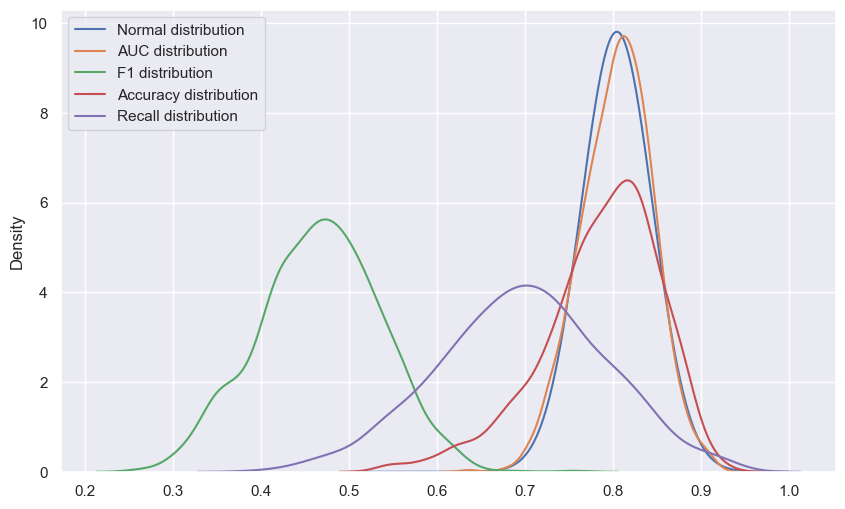

In [25]:
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns
sns.set()
plt.figure(figsize=(10, 6))
x = np.linspace(0.5, 1, 1000)
y = norm.pdf(x, np.mean(final_auc), np.std(final_auc))
plt.plot(x, y, label='Normal distribution')
sns.kdeplot(final_auc, label='AUC distribution')
sns.kdeplot(f1, label='F1 distribution')
sns.kdeplot(accuracy_score_old, label='Accuracy distribution')
sns.kdeplot(recall_score_old, label='Recall distribution')
plt.legend()
plt.show()


In [26]:
feature_importance4_df = pd.DataFrame()
for i in range(0, 1000):
    feature_importance4_df = pd.concat([feature_importance4_df, pd.DataFrame(feature_importance4[i])], axis=1)
feature_importance4_df.index = X.columns

/var/folders/tp/8l2131jx5gq2n7bg70wmjkmc0000gn/T/ipykernel_21864/3736394380.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature_importance4_df['mean'] = feature_importance4_df.mean(axis=1)
/var/folders/tp/8l2131jx5gq2n7bg70wmjkmc0000gn/T/ipykernel_21864/3736394380.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature_importance4_df['std'] = feature_importance4_df.std(axis=1)


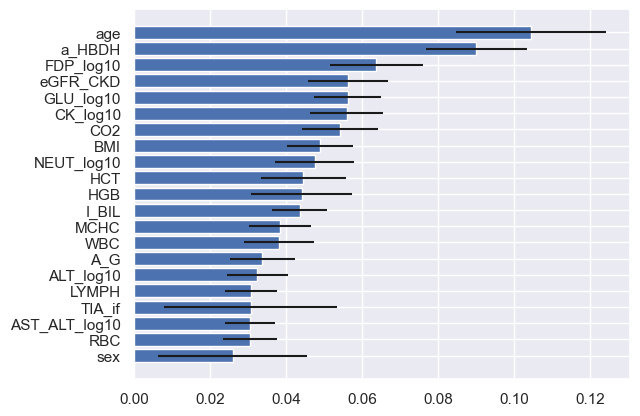

In [27]:
feature_importance4_df['mean'] = feature_importance4_df.mean(axis=1)
feature_importance4_df['std'] = feature_importance4_df.std(axis=1)
feature_importance4_df = feature_importance4_df.sort_values(by='mean', ascending=True)
plt.barh(feature_importance4_df.index, feature_importance4_df['mean'], xerr=feature_importance4_df['std'])
plt.savefig('/Users/gengzhi/Desktop/feature_importance4.pdf',backend='pgf')

In [28]:
shap_values_df = pd.DataFrame()
for i in range(0, 1000):
    shap_values_df = pd.concat([shap_values_df, pd.DataFrame(pd.DataFrame(shap_values[i]).loc[:,1])], axis=1)
shap_values_df.index = X.columns
shap_values_df['mean'] = shap_values_df.mean(axis=1)
shap_values_df['std'] = shap_values_df.std(axis=1)
shap_values_df = shap_values_df.sort_values(by='mean', ascending=True)
plt.barh(shap_values_df.index, shap_values_df['mean'], xerr=shap_values_df['std'])
plt.title('SHAP values for P/N decision')
plt.savefig('/Users/gengzhi/Desktop/shap_values.pdf',backend='pgf')

IndexError: list index out of range